In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import warnings
warnings.filterwarnings("ignore")

In [2]:
%run ingrid_colorbars.py

In [3]:
def load_model(domain,time_start,times,prefix,varlist):
    filelist = [f'{prefix}/{var}.nc' for var in varlist]
    ds = xr.open_mfdataset(filelist,decode_times=False)
    
    if 'X' in ds.coords:
        ds = ds.rename({'Y':'lat','X':'lon'})
    if 'T' in ds.coords:
        ds = ds.rename({'T':'time'})
    if 'P' in ds.coords:
        ds = ds.rename({'P':'plev'})
        
    ds = ds.sortby('lat').sel(lat=slice(domain[2],domain[3]))
    ds.coords['lon'] = (ds.coords['lon'] - domain[0]) % 360 +  domain[0] ; ds = ds.sortby('lon')
    ds = ds.sel(lon=slice(domain[0],domain[1]))
    ds['time'] = pd.date_range(time_start,periods=len(ds.time), freq='MS').shift(15,freq='D')
    ds = ds.sel(time=slice(times[0],times[1]))
    return ds

In [4]:
def get_data(gtype):
    # UCAR - CAM6 - ERSSTv5 - 0.9 x 1.25
    if gtype == 'UCAR':
        prefix_sl = '/net/hodges/d2/naomi/ingrid/UCAR/ERSSTv5/goga/single_level/mean/'
        prefix_pl = '/net/hodges/d2/naomi/ingrid/UCAR/ERSSTv5/goga/pressure_level/mean/from_1950/'
        varlist=['TS', 'PRECC', 'PRECL','OCNFRAC', 'ICEFRAC']

        dst = load_model(domain,'1880-01',time_range,prefix_sl,varlist).sel(time=slice('1950-01','2021-01'))
        dst['PRTOT'] = (dst.PRECC + dst.PRECL) * 1000 * 86400  
        dst['rain'] = dst.PRTOT.where(dst.OCNFRAC<1.0).where(dst.ICEFRAC==0.0)
        dst['Z3'] = (['time','lat','lon'],load_model(domain,'1950-01',time_range,prefix_pl,['Z3']).sel(plev=200, method='nearest').drop(['plev']).Z3)
        ds_anom = dst.groupby('time.month').apply(lambda x: x - x.mean('time'))

    # LDEO - CCM3 - HadISST - T42 ( 2.8 x 2.8)
    if gtype == 'CCM3':
        time_start = '1856-01'
        prefix = '/home/naomi/PROJECTS/CCM3/goga/atm-mean/'
        varlist=['SLD/ORO', 'SLD/TS', 'SLD/PRECC', 'SLD/PRECL']

        dst = load_model(domain,time_start,time_range,prefix,varlist)
        dst['PRTOT'] = (dst.PRECC + dst.PRECL) * 1000 * 86400  
        dst['rain'] = dst.PRTOT.where(dst.ORO==1.0)
        dst['Z3'] = (['time','lat','lon'],load_model(domain,time_start,time_range,prefix,['PLD/Z3']).sel(plev=200, method='nearest').drop(['plev']).Z3)

        ds_anom = dst.groupby('time.month').apply(lambda x: x - x.mean('time'))

    # LDEO - GOGA - HadOIBlend - 1.9 x 2.5
    if gtype == 'CAM6':
        time_start = '1979-01'
        prefix = '/net/hodges/d3/pma2107/forRichard/CAM6/runs/ensemble-extension-fixed/atm/mean/'
        varlist=['SLD/OCNFRAC', 'SLD/TS', 'SLD/ICEFRAC', 'SLD/PRECC', 'SLD/PRECL']

        dst = load_model(domain,time_start,time_range,prefix,varlist)
        dst['PRTOT'] = (dst.PRECC + dst.PRECL) * 1000 * 86400  
        dst['rain'] = dst.PRTOT.where(dst.OCNFRAC<1.0).where(dst.ICEFRAC==0.0)
        dst['Z3'] = (['time','lat','lon'],load_model(domain,time_start,time_range,prefix,['PLD/Z3']).sel(plev=200, method='nearest').drop(['plev']).Z3)

        ds_anom = dst.groupby('time.month').apply(lambda x: x - x.mean('time'))
    return ds_anom

In [19]:
domain = [30, 390, -10,  70]
#domain = [210,310,10,70]

time_range = ['1979-01','2021-05']
time_range = ['1979-01','2020-12']  # UCAR currently only goes to end of 2020

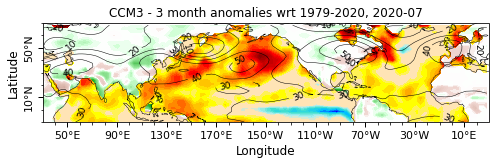

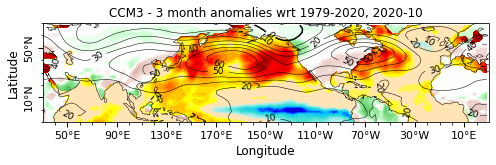

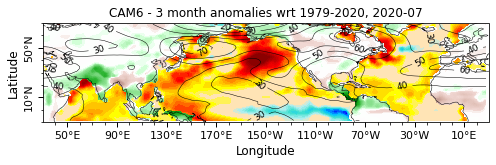

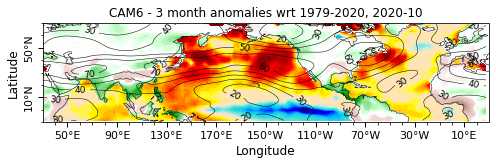

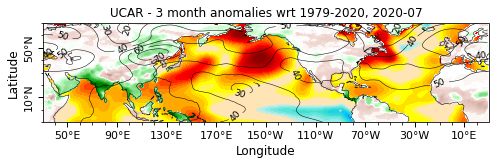

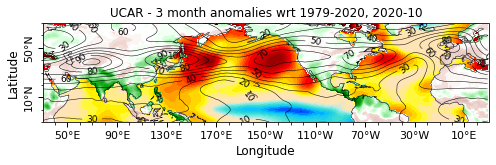

In [20]:
# T 3 boxAverage, starting with 3rd month (March 1979)
for gtype in ['CCM3','CAM6','UCAR']:
    ds_anom = get_data(gtype)
    
    ds_rain = ds_anom.rain[2:].coarsen(time=3,boundary='trim').mean()
    ds_temp = ds_anom.TS[2:].coarsen(time=3,boundary='trim').mean()
    ds_z200 = ds_anom.Z3[2:].coarsen(time=3,boundary='trim').mean()
      
    for month in ['2020-07','2020-10']:  #,'2021-01','2021-04']:
        fig = plt.figure(figsize=(8,4))
        #print(ds_temp.sel(time=f'{month}').time)
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(domain[1]+domain[0])/2))
        ax.set_extent(domain, crs=ccrs.PlateCarree())

        temp = ds_temp.sel(time=month).squeeze().drop(['time'])
        rain = ds_rain.sel(time=month).squeeze().drop(['time'])
        z200 = ds_z200.sel(time=month).squeeze().drop(['time'])

        cb1 = temp.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), zorder = 0, vmin=-2, vmax=2, levels=41, cmap='correlationcolorscale', add_colorbar=False)
        cb2 = rain.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), zorder = 1, vmin=-5, vmax=5, levels=101, cmap='prcp_anomaly', add_colorbar=False)
        # put zorder=10 to put the contours on TOP
        CS  = z200.plot.contour (ax=ax, colors= 'k', linewidths=0.5, transform=ccrs.PlateCarree(),zorder=10, vmin=-160,vmax=160,levels=33)
        ax.clabel(CS, inline=1, fontsize=9, fmt='%1.0f')
        CS.collections[16].set_linewidth(1.5) # plot the zero line thicker

        # Add coasts
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

        # Label x-axis and make tick labels
        ax.xaxis.set_label_text('Longitude',fontsize=12)
        ax.set_xticks(np.arange(domain[0]+20,domain[1],40), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter())
        ax.xaxis.set_minor_locator(MultipleLocator(10))

        # Label y-axis and make tick labels
        ax.yaxis.set_label_text('Latitude',fontsize=12)
        plt.yticks(np.arange(domain[2]+20,domain[3],40), rotation=90, va='center')
        ax.yaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter())
        ax.yaxis.set_minor_locator(MultipleLocator(10))

        # Make tick marks
        ax.tick_params(which='major', width=1.00, length=5, labelsize=11)
        ax.tick_params(which='minor', width=0.75, length=2.5)

        plt.title(f'{gtype} - 3 month anomalies wrt 1979-2020, {month}')
        # do some cropping of the eps file so that we can use it in latex
        plt.savefig('plot.eps')
        os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/{gtype}overlay_{month}.eps');

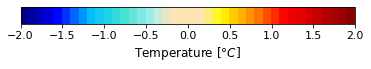

In [7]:
# plot just colorbar:
ds_cutcliptemp=np.clip(ds_temp[0],-2,2)
cb = ds_cutcliptemp.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, levels=41, cmap='correlationcolorscale', add_colorbar=False)
plt.gca().set_visible(False)
cbar = plt.colorbar(cb, extendrect = True, orientation='horizontal')
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='Temperature [$\degree C$]', size=12)
plt.savefig('plot.eps')
os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/temp-colorbar.eps');

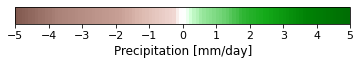

In [8]:
ds_cutclip=np.clip(ds_rain[0],-5,5)
cb = ds_cutclip.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-5,vmax=5, levels=101, cmap='prcp_anomaly', add_colorbar=False)
plt.gca().set_visible(False)
a = np.arange(-5,5.1,1)
cbar = plt.colorbar(cb, extendrect = True, orientation='horizontal', ticks=a)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='Precipitation [mm/day]', size=12)
plt.savefig('plot.eps')
os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/rain-colorbar5.eps');